In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_model_optimization as tfmot

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Diseased (50% - 90% health, depending on severity)',
 'Healthy (100% health)',
 'Pest (25% - 50% health, depending on severity)',
 'Severe Disease (0% - 25% health)']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[0 0 1 3 0 3 3 3 3 3 2 3 0 0 0 3 0 3 0 3 0 2 3 0 0 1 3 3 3 0 0 2]


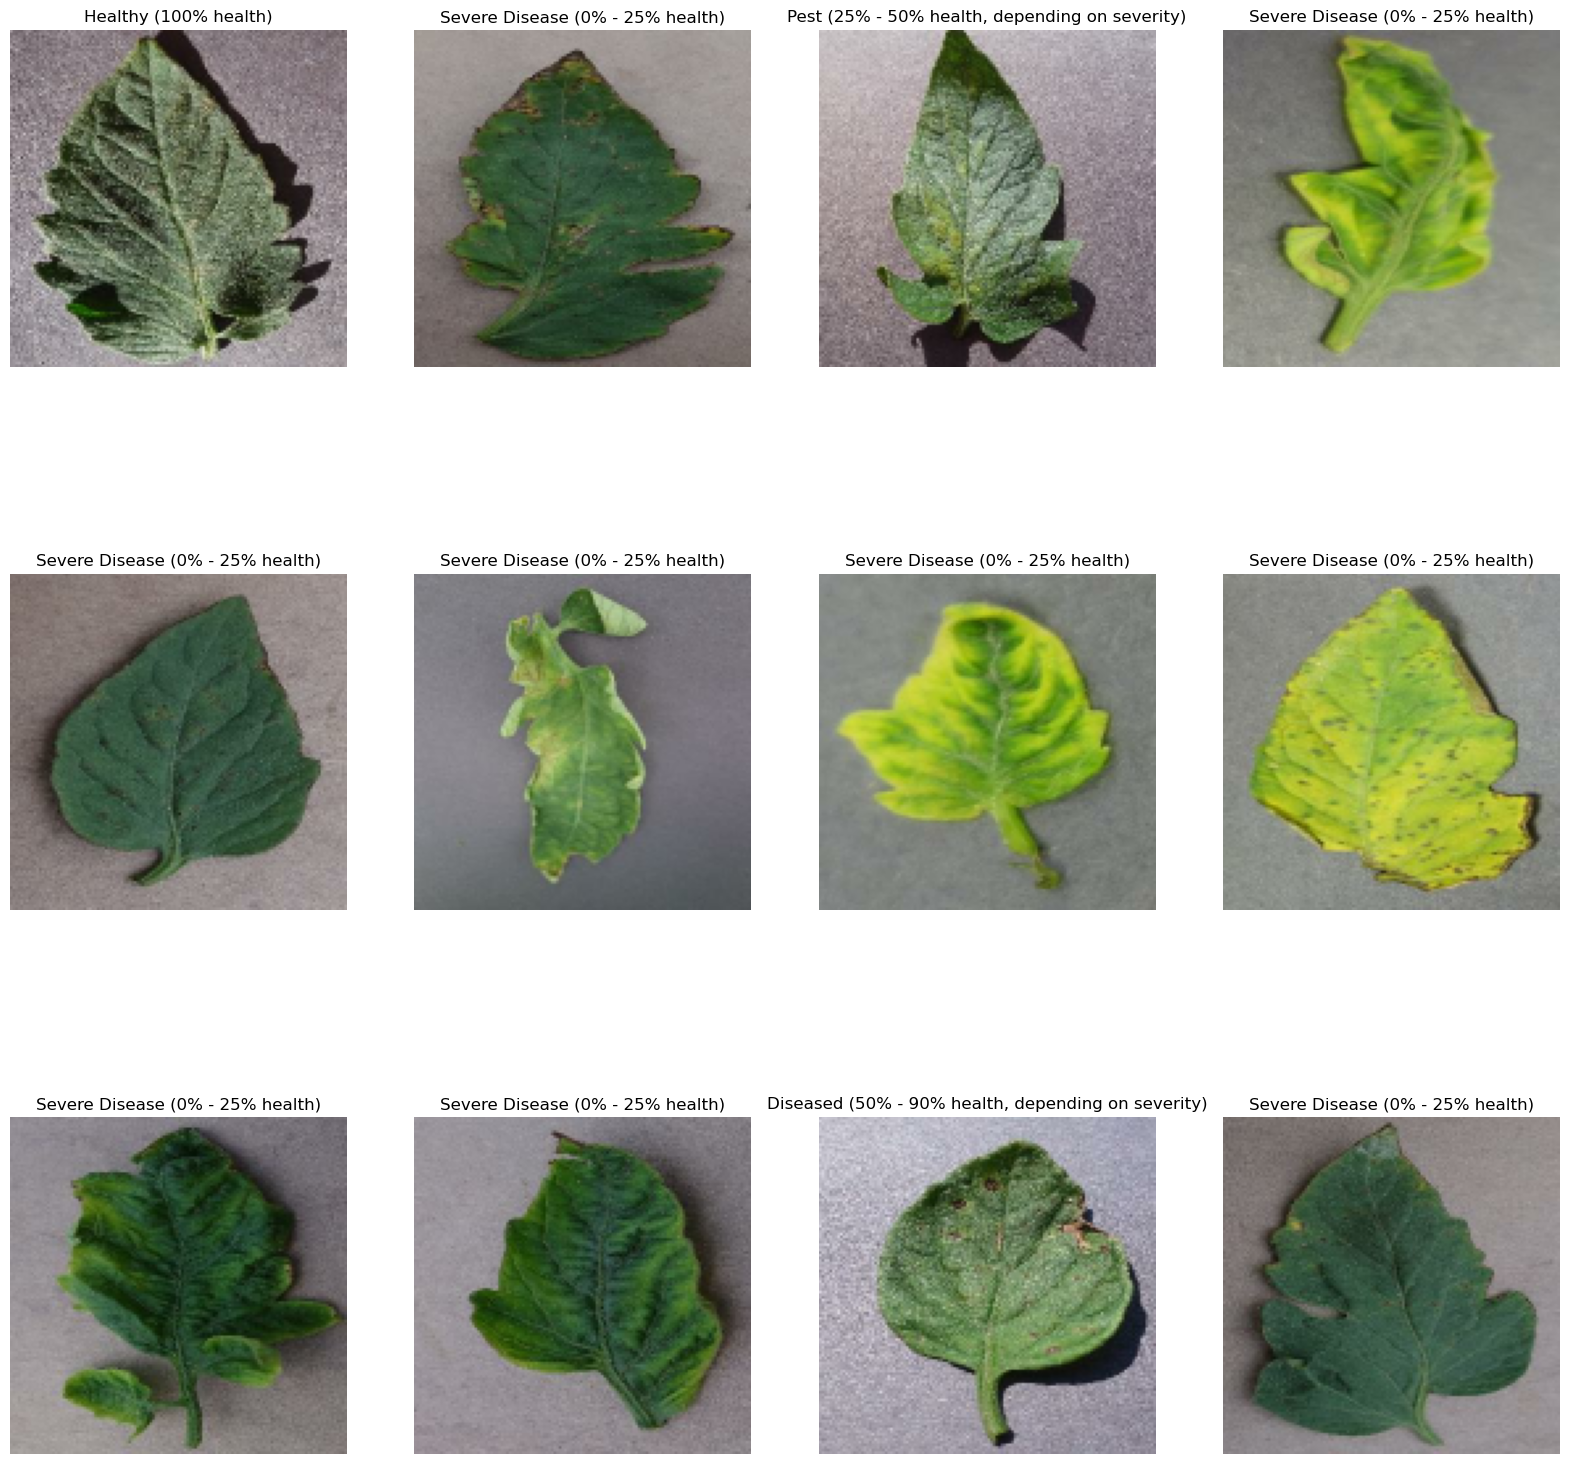

In [6]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, 
            test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

400

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 30, 30, 64)          0         
 g2D)                                                 

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [14]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10


400/400 [==============================] - 79s 171ms/step - loss: 0.7414 - accuracy: 0.6882 - val_loss: 0.6508 - val_accuracy: 0.7244
Epoch 2/10
400/400 [==============================] - 63s 158ms/step - loss: 0.4097 - accuracy: 0.8372 - val_loss: 0.3274 - val_accuracy: 0.8725
Epoch 3/10
400/400 [==============================] - 65s 161ms/step - loss: 0.3556 - accuracy: 0.8603 - val_loss: 0.3087 - val_accuracy: 0.8863
Epoch 4/10
400/400 [==============================] - 67s 168ms/step - loss: 0.2976 - accuracy: 0.8816 - val_loss: 0.3270 - val_accuracy: 0.8744
Epoch 5/10
400/400 [==============================] - 80s 201ms/step - loss: 0.2602 - accuracy: 0.8991 - val_loss: 0.2553 - val_accuracy: 0.9025
Epoch 6/10
400/400 [==============================] - 81s 204ms/step - loss: 0.2266 - accuracy: 0.9113 - val_loss: 0.5882 - val_accuracy: 0.7881
Epoch 7/10
400/400 [==============================] - 75s 188ms/step - loss: 0.2360 - accuracy: 0.9107 - val_loss: 0.1819 - val_

In [15]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 7s 38ms/step - loss: 0.1580 - accuracy: 0.9369


In [16]:
scores

[0.15800191462039948, 0.936887264251709]

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

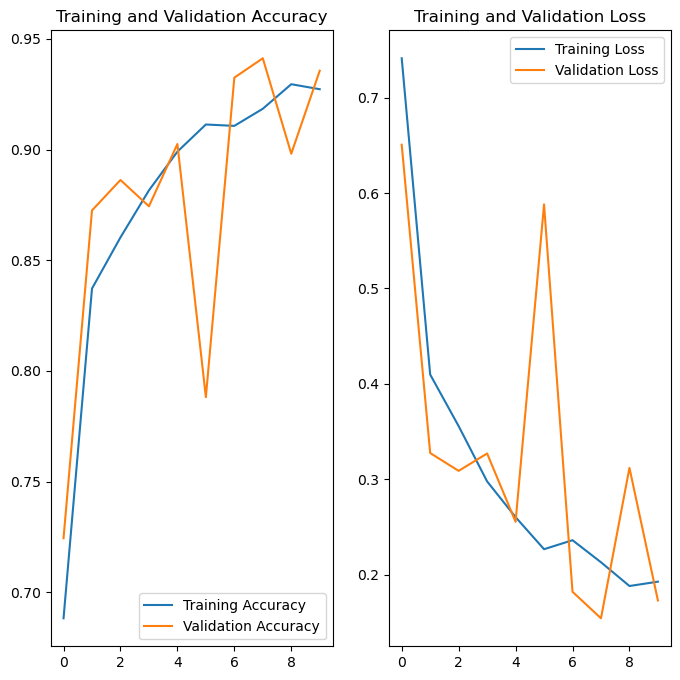

In [18]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
import os
model_version=max([int(i) for i in os.listdir("model") + [0]])+1
model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/1\assets


INFO:tensorflow:Assets written to: model/1\assets


In [21]:
keras_model = "tomato.h5"
model.save(keras_model)

C:\Users\its_y\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
tlm = "tf_lite_model.tflite"

In [23]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\its_y\AppData\Local\Temp\tmp_qy0s__v\assets


INFO:tensorflow:Assets written to: C:\Users\its_y\AppData\Local\Temp\tmp_qy0s__v\assets


In [24]:
tflite_model_name = tlm
open(tflite_model_name, "wb").write(tflite_model)

3714744

In [25]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [26]:
input_details

[{'name': 'serving_default_sequential_input:0',
  'index': 0,
  'shape': array([  1, 128, 128,   3]),
  'shape_signature': array([ -1, 128, 128,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [27]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [29]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [30]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 quant_conv2d (QuantizeWrap  (None, 126, 126, 32)      963       
 perV2)                                                          
                                                                 
 quant_max_pooling2d (Quant  (None, 63, 63, 32)        1         
 izeWrapperV2)                                                   
                                                                 
 quant_conv2d_1 (QuantizeWr  (None, 61, 61, 64)        18627     
 apperV2)                                                        
                                                      

In [31]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10
400/400 [==============================] - 100s 243ms/step - loss: 0.1892 - accuracy: 0.9311 - val_loss: 0.3266 - val_accuracy: 0.8763
Epoch 2/10
400/400 [==============================] - 98s 245ms/step - loss: 0.1796 - accuracy: 0.9327 - val_loss: 0.4657 - val_accuracy: 0.8631
Epoch 3/10
400/400 [==============================] - 101s 251ms/step - loss: 0.1801 - accuracy: 0.9309 - val_loss: 0.1423 - val_accuracy: 0.9450
Epoch 4/10
400/400 [==============================] - 97s 242ms/step - loss: 0.1560 - accuracy: 0.9426 - val_loss: 0.1902 - val_accuracy: 0.9337
Epoch 5/10
400/400 [==============================] - 96s 241ms/step - loss: 0.1404 - accuracy: 0.9467 - val_loss: 0.1857 - val_accuracy: 0.9294
Epoch 6/10
400/400 [==============================] - 94s 236ms/step - loss: 0.1417 - accuracy: 0.9466 - val_loss: 0.2052 - val_accuracy: 0.9262
Epoch 7/10
400/400 [==============================] - 99s 248ms/step - loss: 0.1307 - accuracy: 0.9524 - val_loss: 0.2697 - val_

In [33]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [34]:
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
51/51 [==============================] - 3s 56ms/step - loss: 0.0941 - accuracy: 0.9638
Test Accuracy: 96.38%


In [35]:
tlqm = "tf_lite_quantized_model.tflite"

In [36]:
tf_lite_quantized_model = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
tf_lite_quantized_model.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_quantized_model.target_spec.supported_types = [tf.float16]
quantized_tflite_model = tf_lite_quantized_model.convert()

INFO:tensorflow:Assets written to: C:\Users\its_y\AppData\Local\Temp\tmpn7yu07cc\assets


INFO:tensorflow:Assets written to: C:\Users\its_y\AppData\Local\Temp\tmpn7yu07cc\assets
C:\Users\its_y\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [37]:
tf_lite_quantized_model = tlqm
open(tf_lite_quantized_model, "wb").write(quantized_tflite_model)

3716088

In [38]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Quant TFLite test_accuracy: 0.9659609018799575


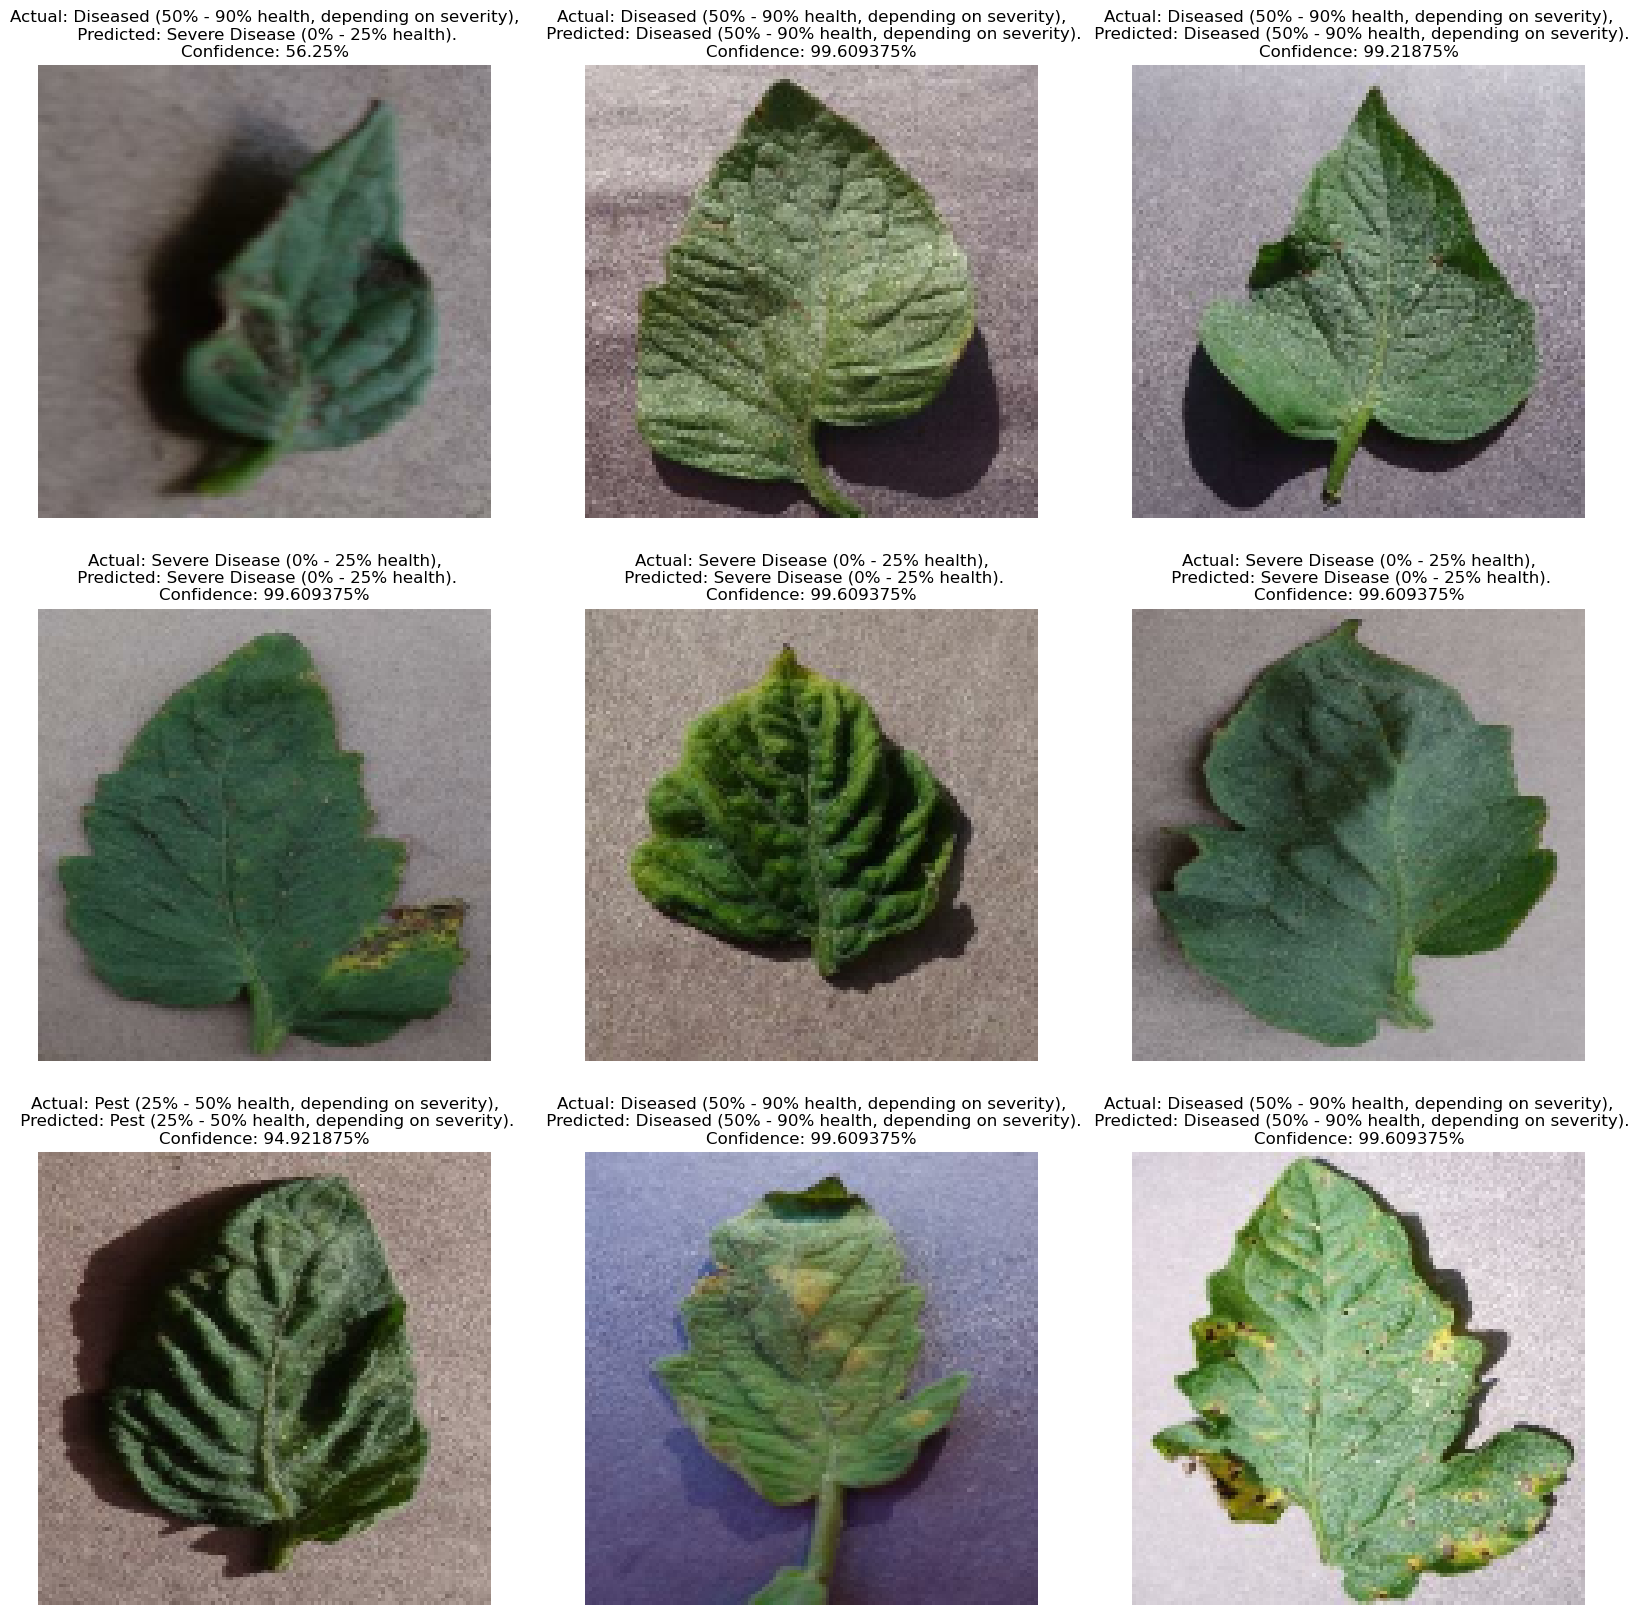

In [41]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\nConfidence: {confidence}%")
        plt.axis("off")